In [0]:
import pandas as pd
import numpy as np
from joblib import dump,load

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
import cv2

## Set up the dataset

Load the dataset by using the joblib library

In [14]:
df = load("finger_count_dataset_3")
df_test = load("stian_dataset")
df.head()

,image,count
1068_r90_m.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
903_r135_m.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
927_r270_m.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
999_r90.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1041_r180_m.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


Set up the sample (X) and target (y) values. We will then do a Kfold cross validation on these to measure the performance of the classifiers

In [0]:
df = shuffle(df)[:5000]
X = df["image"]
y = df["count"]
X_test = df_test["image"]
y_test = df_test["count"]
cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [17]:
len(df.image)

5000

## Model Selection

### Hyperparameter tuning
Hyperparameter tuning using a random hyperparameter grid search will randomly sample from the grid and perform K-Fold CV with each combination of values in order to find optimized combinations. RandomizedSearchCV_report will generate a report containing top accuracy scores and plots for each hyperparameter.

In [0]:
#inspired by https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search

def RandomizedSearchCV_report(random_clf, parameters,num_res=5):
    opt_clf_params = random_clf.best_params_ #The best combination of hyperparameters
    opt_clf_score = random_clf.best_score_ 
    opt_cv_results = random_clf.cv_results_
    opt_clf_stdev = random_clf.cv_results_['std_test_score'][random_clf.best_index_]
    
    print("best parameters: {}".format(opt_clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(opt_clf_score, opt_clf_stdev))
    
    rem_columns = ["std_fit_time","std_score_time", "params"]
    display(pd.DataFrame(opt_cv_results).sort_values(by='rank_test_score').drop(rem_columns, axis = 1) .head(num_res))
    
    #Plot the behavior for each hyperparameter
    df_top_rank = pd.DataFrame(opt_cv_results).sort_values(by='rank_test_score')
    
    rows = len(parameters)/2
    if not (rows).is_integer(): 
        rows=int(rows)+1
    #Subplots with 2 columns and necessary amount of rows    
    fig, axs = plt.subplots(int(rows),2, figsize=(15, 5*rows), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    fig.suptitle('Hyperparameter plots')
    
    for i,param in enumerate(parameters): #Generate each subplot
        best_row = df_top_rank.iloc[0, :]

        best_mean = best_row['mean_test_score']
        best_stdev = best_row['std_test_score']
        best_param = best_row['param_'+param]
        
        df_scores = df_top_rank.sort_values(by='param_' + param)
        
        means = df_scores['mean_test_score']
        stds = df_scores['std_test_score']
        params = df_scores['param_' + param]

        #axs[i].errorbar(params, means, yerr=stds, color="mediumblue")
        axs[i].errorbar(params, means, color="mediumblue")
        axs[i].axhline(y=best_mean + best_stdev, color="red")
        axs[i].axhline(y=best_mean - best_stdev, color='red')
        axs[i].plot(best_param, best_mean, 'og')
        axs[i].set(xlabel=param, ylabel='Score')

### Model evaluation
Create model report

In [0]:
def compare_base_optimized(opt_clf, base_clf, X_test, y_test, k):
    opt_preds = cross_val_score(opt_clf, X_test, y_test, cv=k)
    base_preds = cross_val_score(base_clf, X_test, y_test, cv=k)
    
    print('Accuracy for optimized values = {:0.4f}.'.format(opt_preds.mean()))
    print('Accuracy for base values = {:0.4f}.'.format(base_preds.mean()))

In [0]:
def plot_learning_curve(training_scores, training_sizes, testing_scores, model_name):
    # Create means and standard deviations of training set scores
    std_train = np.std(training_scores, axis=1)
    mean_train = np.mean(training_scores, axis=1)

    std_test = np.std(testing_scores, axis=1)
    mean_test = np.mean(testing_scores, axis=1)
    
    fig = plt.figure(figsize=(15,7))
    
    plt.plot(training_sizes, mean_train, 'o--', color="dimgrey",  label="Training score")
    plt.plot(training_sizes, mean_test, 'o-', color="dimgrey", label="Cross-validation score")

    plt.fill_between(training_sizes, mean_train - std_train, mean_train + std_train, color="lightgreen")
    plt.fill_between(training_sizes, mean_test - std_test, mean_test + std_test, color="lightgreen")

    plt.title("Learning Curve for {}".format(model_name))
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.show()

### Random Forest

#### Find optimized hyperparameters

In [21]:
#Propose some hyperparameters we want to test with
n_estimators = [20, 50, 100, 300, 500, 800]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

rf = RandomForestClassifier(random_state = 25)

hyper = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = hyper,
                   n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_best_fit = rf_random.fit(list(X), y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 57.7min finished


best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 25}
best score:      0.81260 (+/-0.00440)


,mean_fit_time,mean_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
40,15.520108,1.026463,500,2,1,25,0.814149,0.817037,0.806607,0.8126,0.004396,1
49,12.408368,0.866842,500,5,1,30,0.802758,0.802639,0.794595,0.8000,0.003820,2
14,9.399680,0.845311,300,5,1,25,0.798561,0.795441,0.791592,0.7952,0.002850,3
37,22.561015,1.214726,800,2,2,30,0.793765,0.796641,0.787988,0.7928,0.003597,4
24,3.710829,0.689359,100,5,1,25,0.785971,0.791842,0.775976,0.7846,0.006548,5


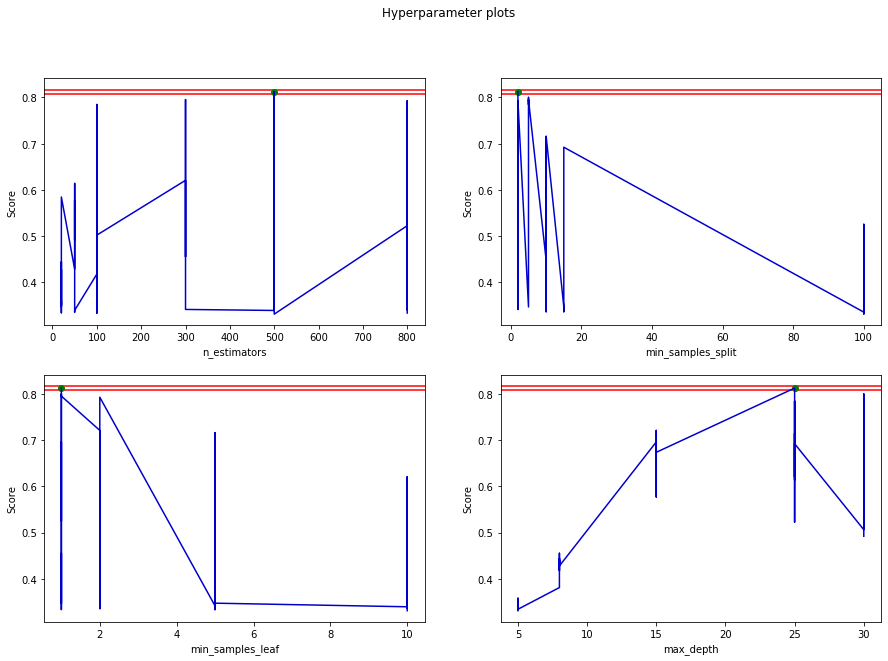

In [22]:
RandomizedSearchCV_report(rf_random, ["n_estimators","min_samples_split", "min_samples_leaf", "max_depth"])

In [23]:
#Compare the optimized parameters with the default parameters
rf_base_clf = RandomForestClassifier(n_estimators=100)
rf_opt_clf = rf_random.best_estimator_ #Classifier trained on top parameters

X_test = list(X)
y_test = y

compare_base_optimized(rf_opt_clf, rf_base_clf, X_test, y_test, 5)

Accuracy for optimized values = 0.8352.
Accuracy for base values = 0.8324.


#### Now train a model based on the hyperparameters we think is suited for this problem

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


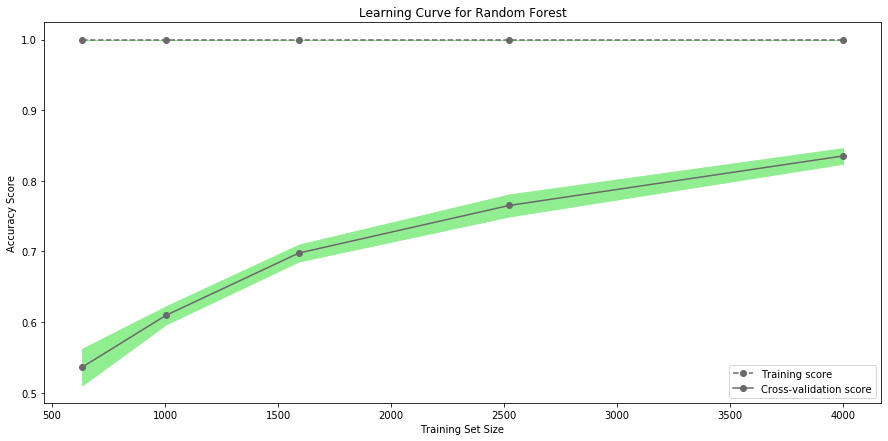

Evaluation of the Random Forest classifier

We achieved the maximum accuracy with a training set of size:  3999
Maximum accuracy: 0.835
Standard deviation: 0.011


In [24]:
#Evaluate the learning curve, which shows how to  Tells if the model is underfitting or overfitting. 
rf_train_sizes, rf_train_scores, rf_test_scores = learning_curve(rf_opt_clf, 
                                                        list(X), 
                                                        y,
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1, 
                                                        #could also use linespace, but want to focus
                                                        #on small training sizes (in case they perform very good)
                                                        train_sizes=np.logspace(0.2, 1.0, 5)/10)
plot_learning_curve(rf_train_scores, rf_train_sizes, rf_test_scores, "Random Forest")

max_idx = np.argmax(np.mean(rf_test_scores, axis=1))
rf_max_acc = np.mean(rf_test_scores, axis=1)[max_idx]
rf_max_std = np.std(rf_test_scores, axis=1)[max_idx]
rf_max_tsize = rf_train_sizes[max_idx]

print("Evaluation of the Random Forest classifier\n")
print("We achieved the maximum accuracy with a training set of size: ", rf_max_tsize)
print('Maximum accuracy: {:0.3f}'.format(rf_max_acc))
print('Standard deviation: {:0.3f}'.format(rf_max_std))

### Support Vector Classification (SVC)

In [25]:
#Propose some hyperparameters we want to test with
gammas = [0.001, 0.01, 0.05]
degrees = range(1,10)

svc = SVC(random_state = 25)

hyper = dict(gamma = gammas, degree=degrees)

svc_random = RandomizedSearchCV(estimator = svc, param_distributions = hyper,
                   n_iter = 15, cv = 3, verbose=2, random_state=42, n_jobs = -1)

svc_best_fit = svc_random.fit(list(X), y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 45.6min finished


best parameters: {'gamma': 0.01, 'degree': 5}
best score:      0.80360 (+/-0.00388)


,mean_fit_time,mean_score_time,param_gamma,param_degree,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,91.110538,30.179069,0.01,5,0.808753,0.802639,0.799399,0.8036,0.003878,1
6,85.863267,33.119144,0.01,6,0.808753,0.802639,0.799399,0.8036,0.003878,1
10,91.727427,28.092891,0.01,1,0.808753,0.802639,0.799399,0.8036,0.003878,1
11,86.531654,33.262027,0.01,2,0.808753,0.802639,0.799399,0.8036,0.003878,1
0,95.497051,28.513396,0.05,3,0.561151,0.583683,0.568769,0.5712,0.009360,5


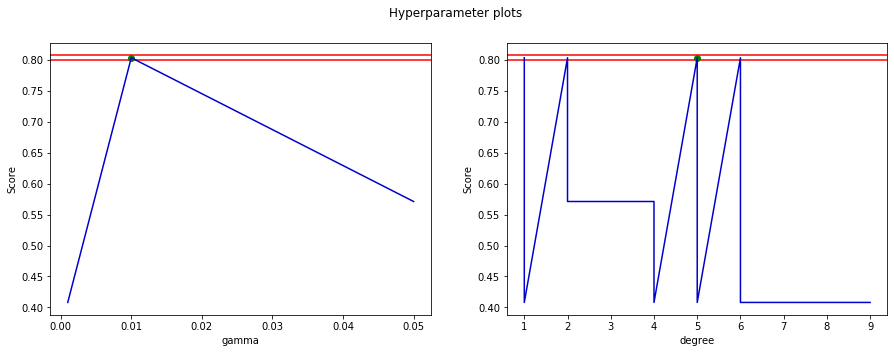

In [26]:
RandomizedSearchCV_report(svc_random, ["gamma","degree"])

In [27]:
#Compare the optimized parameters with the default parameters
svc_base_clf = SVC(gamma=0.001)
svc_opt_clf = svc_random.best_estimator_

X_test = list(X)
y_test = y

compare_base_optimized(svc_opt_clf, svc_base_clf, X_test, y_test, 5)

Accuracy for optimized values = 0.8326.
Accuracy for base values = 0.4470.


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


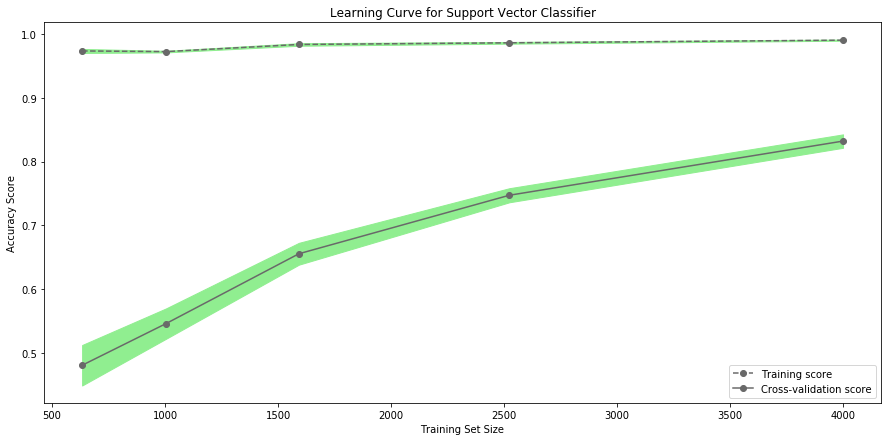

Evaluation of the Random Forest classifier

We achieved the maximum accuracy with a training set of size:  3999
Maximum accuracy: 0.832
Standard deviation: 0.011


In [28]:
#Evaluate the learning curve, which shows how to  Tells if the model is underfitting or overfitting. 
svc_train_sizes, svc_train_scores, svc_test_scores = learning_curve(svc_opt_clf, 
                                                        list(X), 
                                                        y,
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1, 
                                                        #could also use linespace, but want to focus
                                                        #on small training sizes (in case they perform very good)
                                                        train_sizes=np.logspace(0.2, 1.0, 5)/10)
plot_learning_curve(svc_train_scores, svc_train_sizes, svc_test_scores, "Support Vector Classifier")

max_idx = np.argmax(np.mean(svc_test_scores, axis=1))
svc_max_acc = np.mean(svc_test_scores, axis=1)[max_idx]
svc_max_std = np.std(svc_test_scores, axis=1)[max_idx]
svc_max_tsize = svc_train_sizes[max_idx]

print("Evaluation of the Random Forest classifier\n")
print("We achieved the maximum accuracy with a training set of size: ", svc_max_tsize)
print('Maximum accuracy: {:0.3f}'.format(svc_max_acc))
print('Standard deviation: {:0.3f}'.format(svc_max_std))

### Decision Tree

In [29]:
#Propose some hyperparameters we want to test with
max_depths = range(1, 70, 3)
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)


dtree = tree.DecisionTreeClassifier(random_state = 25)

hyper = dict(max_depth = max_depths, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)

dtree_random = RandomizedSearchCV(estimator = dtree, param_distributions = hyper,
                   n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)

dtree_best_fit = dtree_random.fit(list(X), y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 19.6min finished


best parameters: {'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_depth': 22}
best score:      0.31680 (+/-0.00689)


,mean_fit_time,mean_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,1.477894,0.601903,0.2,0.1,22,0.325540,0.316137,0.308709,0.3168,0.006887,1
1,1.428768,0.604204,0.3,0.1,46,0.311151,0.316137,0.308709,0.3120,0.003091,2
0,1.304036,0.593622,0.5,0.3,10,0.317746,0.316137,0.299700,0.3112,0.008152,3
16,1.319638,0.597399,0.6,0.3,55,0.317746,0.316137,0.299700,0.3112,0.008152,3
12,1.323719,0.594213,0.2,0.3,55,0.317746,0.316137,0.299700,0.3112,0.008152,3


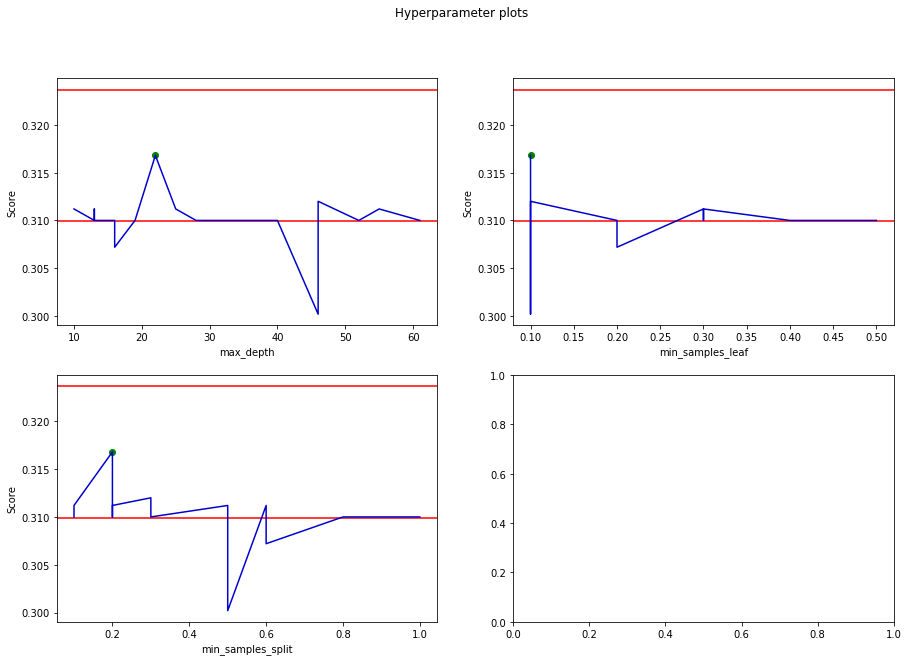

In [30]:
RandomizedSearchCV_report(dtree_random, ["max_depth","min_samples_leaf","min_samples_split"])

In [31]:
#Compare the optimized parameters with the default parameters
dtree_base_clf = tree.DecisionTreeClassifier()
dtree_opt_clf = dtree_random.best_estimator_

X_test = list(X)
y_test = y

compare_base_optimized(dtree_opt_clf, dtree_base_clf, X_test, y_test, 5)

Accuracy for optimized values = 0.3182.
Accuracy for base values = 0.6368.


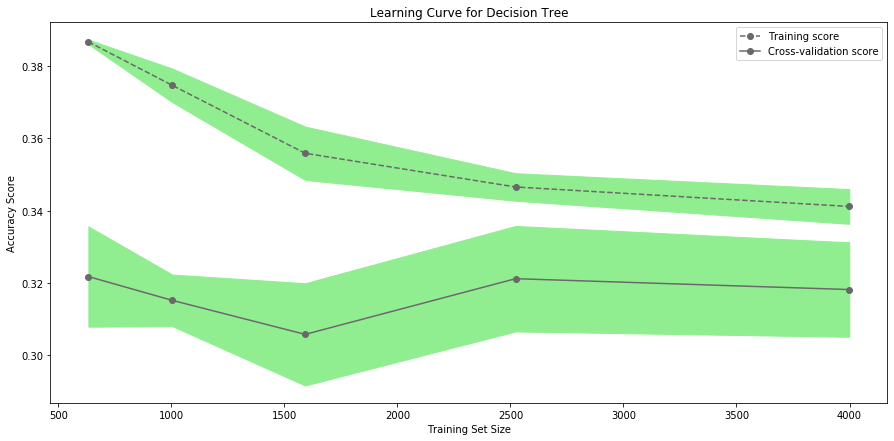

Evaluation of the Random Forest classifier

We achieved the maximum accuracy with a training set of size:  633
Maximum accuracy: 0.322
Standard deviation: 0.014


In [32]:
#Evaluate the learning curve, which shows how to  Tells if the model is underfitting or overfitting. 
dtree_train_sizes, dtree_train_scores, dtree_test_scores = learning_curve(dtree_opt_clf, 
                                                        list(X), 
                                                        y,
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1, 
                                                        #could also use linespace, but want to focus
                                                        #on small training sizes (in case they perform very good)
                                                        train_sizes=np.logspace(0.2, 1.0, 5)/10)
plot_learning_curve(dtree_train_scores, dtree_train_sizes, dtree_test_scores, "Decision Tree")

max_idx = np.argmax(np.mean(dtree_test_scores, axis=1))
dtree_max_acc = np.mean(dtree_test_scores, axis=1)[max_idx]
dtree_max_std = np.std(dtree_test_scores, axis=1)[max_idx]
dtree_max_tsize = dtree_train_sizes[max_idx]

print("Evaluation of the Random Forest classifier\n")
print("We achieved the maximum accuracy with a training set of size: ", dtree_max_tsize)
print('Maximum accuracy: {:0.3f}'.format(dtree_max_acc))
print('Standard deviation: {:0.3f}'.format(dtree_max_std))